In [36]:
#This is our code for the ML Project in EENG 680
#datasets have been uploaded with 400 samples per folder

In [37]:
!pip install opencv-python 
import os
import random
import pandas as pd
import cv2
import numpy as np

In [38]:
#changing all images to grayscale for consistency

raw_root_eyes = ["Merged_Datasets/closed_eye_no_yawn/closed_eye", 
                 "Merged_Datasets/closed_eye_yawn/closed_eye", 
                 "Merged_Datasets/open_eye_no_yawn/open_eye", 
                 "Merged_Datasets/open_eye_yawn/open_eye"]
processed_root_eyes = ["Processed_Datasets/closed_eye_no_yawn/closed_eye", 
                       "Processed_Datasets/closed_eye_yawn/closed_eye", 
                       "Processed_Datasets/open_eye_no_yawn/open_eye", 
                       "Processed_Datasets/open_eye_yawn/open_eye"]    

raw_root_mouth = ["Merged_Datasets/closed_eye_no_yawn/no_yawn", 
                  "Merged_Datasets/closed_eye_yawn/yawn", 
                  "Merged_Datasets/open_eye_no_yawn/no_yawn", 
                  "Merged_Datasets/open_eye_yawn/yawn"]
processed_root_mouth = ["Processed_Datasets/closed_eye_no_yawn/no_yawn", 
                        "Processed_Datasets/closed_eye_yawn/yawn", 
                        "Processed_Datasets/open_eye_no_yawn/no_yawn", 
                        "Processed_Datasets/open_eye_yawn/yawn"]

TARGET_SIZE = (128, 128)
#for contrast enhancement
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

#for brightness adjustment - for eye images only 
def adjust_gamma(image, gamma=0.6):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(image, table)


def preprocess_eye(input_path, output_path):
    img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Cannot load image: {input_path}")
        return
    img = cv2.resize(img, TARGET_SIZE)
    img = adjust_gamma(img, gamma=0.6)  #brightening
    cv2.imwrite(output_path, img)


def preprocess_mouth(input_path, output_path):
    img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Cannot load image: {input_path}")
        return
    img = cv2.resize(img, TARGET_SIZE)
    cv2.imwrite(output_path, img)


def preprocess_folder(input_dir, output_dir, is_eye=True):
    os.makedirs(output_dir, exist_ok=True)

    for filename in os.listdir(input_dir):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)

        if not os.path.isfile(input_path):
            continue

        if is_eye:
            preprocess_eye(input_path, output_path)
        else:
            preprocess_mouth(input_path, output_path)


# Process all EYE folders
for raw, processed in zip(raw_root_eyes, processed_root_eyes):
    preprocess_folder(raw, processed, is_eye=True)

# Process all MOUTH folders
for raw, processed in zip(raw_root_mouth, processed_root_mouth):
    preprocess_folder(raw, processed, is_eye=False)


In [39]:
import os
import random
import pandas as pd
import cv2

#making dataframes for the mixed dataset folders to create random pairs of eye and mouth (yawn state) samples so the training model reads them as one sample
#closed eye and no yawn

closed_eye_dir = "Processed_Datasets/closed_eye_no_yawn/closed_eye"
no_yawn_dir =  "Processed_Datasets/closed_eye_no_yawn/no_yawn"


#output folder to combinie the images into 1 for easier processing
output_dir = "Combined_Dataset/closed_eye_no_yawn"
os.makedirs(output_dir, exist_ok=True)

random_seed = 42
pairing_mode = "random"

random.seed(random_seed)

images_closed_eye = [os.path.abspath(os.path.join(closed_eye_dir, f)) for f in os.listdir(closed_eye_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
images_no_yawn = [os.path.abspath(os.path.join(no_yawn_dir, f)) for f in os.listdir(no_yawn_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]


#sort for reproducibiltiy
images_closed_eye.sort()
images_no_yawn.sort()

random.shuffle(images_closed_eye)
random.shuffle(images_no_yawn)

min_len = min(len(images_closed_eye), len(images_no_yawn))
pairs = list(zip(images_closed_eye[:min_len], images_no_yawn[:min_len]))

csv_rows = []

for idx, (eye_path, mouth_path) in enumerate(pairs):

    #read images
    eye = cv2.imread(eye_path)
    mouth = cv2.imread(mouth_path)

    #skip missing images 
    if eye is None or mouth is None:
        continue

    #resize images to 128x128
    eye = cv2.resize(eye, (128, 128))
    mouth = cv2.resize(mouth, (128, 128))

    #combine the images side by side
    combined = cv2.hconcat([eye, mouth])

    #save combined image
    save_path = os.path.join(output_dir, f"sample_{idx:04d}.jpg")
    cv2.imwrite(save_path, combined)

    # Add row to CSV
    csv_rows.append([save_path, 2])   # label 2 = closed eyes and no yawn - more drowsy state

# Save CSV
df_closed_no_yawn = pd.DataFrame(csv_rows, columns=['combined_image_path', 'label'])
df_closed_no_yawn.to_csv("combined_closed_eye_no_yawn.csv", index=False)

print(df_closed_no_yawn.head())

                                 combined_image_path  label
0  Combined_Dataset/closed_eye_no_yawn/sample_000...      2
1  Combined_Dataset/closed_eye_no_yawn/sample_000...      2
2  Combined_Dataset/closed_eye_no_yawn/sample_000...      2
3  Combined_Dataset/closed_eye_no_yawn/sample_000...      2
4  Combined_Dataset/closed_eye_no_yawn/sample_000...      2


In [40]:
#trying to see what the paths look like and if they actually exist cause i cannot access the images through the created .csv
test_df = pd.read_csv("paired_closed_eye_no_yawn.csv")
#print(test_df.head())

#print(test_df['images_closed_eye_path'][0])
#print(test_df['images_no_yawn_path'][0])

test_path = test_df['images_no_yawn_path'][0]
print(test_path)
print(os.path.exists(test_path))

print("Current working dir:", os.getcwd())



/Users/leilatawfik/Desktop/FALL 2025/ENGG680_ML_Project/Merged_Datasets/closed_eye_no_yawn/no_yawn/2837.jpg
True
Current working dir: /Users/leilatawfik/Desktop/FALL 2025/ENGG680_ML_Project


In [41]:
#testing to see if the absolute path command works

relative_path = "C:/Users/saumy/Desktop/ENGG680_ML_Project/Merged_Datasets/closed_eye_no_yawn/no_yawn/2837.jpg"
absolute_path = os.path.abspath(relative_path)

print(f"The absolute path is: {absolute_path}")

#i am so confused - i am assuming it works

The absolute path is: /Users/leilatawfik/Desktop/FALL 2025/ENGG680_ML_Project/C:/Users/saumy/Desktop/ENGG680_ML_Project/Merged_Datasets/closed_eye_no_yawn/no_yawn/2837.jpg


In [42]:
#making dataframes for the mixed dataset folders to create random pairs of eye and mouth (yawn state) samples so the training model reads them as one sample
#closed eye and yawn

closed_eye_dir2 = "Processed_Datasets/closed_eye_yawn/closed_eye"
yawn_dir =  "Processed_Datasets/closed_eye_yawn/yawn"
random_seed = 42
pairing_mode = "random"

random.seed(random_seed)

images_closed_eye2 = [os.path.abspath(os.path.join(closed_eye_dir2, f)) for f in os.listdir(closed_eye_dir2) if f.lower().endswith(('.jpg', '.png'))]
images_yawn = [os.path.abspath(os.path.join(yawn_dir, f)) for f in os.listdir(yawn_dir) if f.lower().endswith(('.jpg', '.png'))]

#output folder to combinie the images into 1 for easier processing
output_dir = "Combined_Dataset/closed_eye_yawn"
os.makedirs(output_dir, exist_ok=True)

#sort for reproducibiltiy
images_closed_eye2.sort()
images_yawn.sort()

random.shuffle(images_closed_eye2)
random.shuffle(images_yawn)


min_len = min(len(images_closed_eye2), len(images_yawn))
pairs = list(zip(images_closed_eye2[:min_len], images_yawn[:min_len]))

csv_rows = []

for idx, (eye_path, mouth_path) in enumerate(pairs):

    #read images
    eye = cv2.imread(eye_path)
    mouth = cv2.imread(mouth_path)

    #skip missing images 
    if eye is None or mouth is None:
        continue

    #resize images to 128x128
    eye = cv2.resize(eye, (128, 128))
    mouth = cv2.resize(mouth, (128, 128))

    #combine the images side by side
    combined = cv2.hconcat([eye, mouth])

    #save combined image
    save_path = os.path.join(output_dir, f"sample_{idx:04d}.jpg")
    cv2.imwrite(save_path, combined)

    # Add row to CSV
    csv_rows.append([save_path, 3])   # label 3 = closed eyes and yawn - most drowsy state

# Save CSV
df_closed_yawn = pd.DataFrame(csv_rows, columns=['combined_image_path', 'label'])
df_closed_yawn.to_csv("combined_closed_eye_yawn.csv", index=False)

print(df_closed_yawn.head())



                                combined_image_path  label
0  Combined_Dataset/closed_eye_yawn/sample_0000.jpg      3
1  Combined_Dataset/closed_eye_yawn/sample_0001.jpg      3
2  Combined_Dataset/closed_eye_yawn/sample_0002.jpg      3
3  Combined_Dataset/closed_eye_yawn/sample_0003.jpg      3
4  Combined_Dataset/closed_eye_yawn/sample_0004.jpg      3


In [43]:
#making dataframes for the mixed dataset folders to create random pairs of eye and mouth (yawn state) samples so the training model reads them as one sample
#open eye and no yawning

open_eye_dir = "Processed_Datasets/open_eye_no_yawn/open_eye"
no_yawn_dir2 =  "Processed_Datasets/open_eye_no_yawn/no_yawn"
random_seed = 42
pairing_mode = "random"

random.seed(random_seed)

images_open_eye = [os.path.abspath(os.path.join(open_eye_dir, f)) for f in os.listdir(open_eye_dir) if f.lower().endswith(('.jpg', '.png'))]
images_no_yawn2 = [os.path.abspath(os.path.join(no_yawn_dir2, f)) for f in os.listdir(no_yawn_dir2) if f.lower().endswith(('.jpg', '.png'))]

#sort for reproducibiltiy
images_open_eye.sort()
images_no_yawn2.sort()

#output folder to combinie the images into 1 for easier processing
output_dir = "Combined_Dataset/open_eye_no_yawn"
os.makedirs(output_dir, exist_ok=True)

random.shuffle(images_open_eye)
random.shuffle(images_no_yawn2)

min_len = min(len(images_open_eye), len(images_no_yawn2))
pairs = list(zip(images_open_eye[:min_len], images_no_yawn2[:min_len]))

csv_rows = []

for idx, (eye_path, mouth_path) in enumerate(pairs):

    #read images
    eye = cv2.imread(eye_path)
    mouth = cv2.imread(mouth_path)

    #skip missing images 
    if eye is None or mouth is None:
        continue

    #resize images to 128x128
    eye = cv2.resize(eye, (128, 128))
    mouth = cv2.resize(mouth, (128, 128))

    #combine the images side by side
    combined = cv2.hconcat([eye, mouth])

    #save combined image
    save_path = os.path.join(output_dir, f"sample_{idx:04d}.jpg")
    cv2.imwrite(save_path, combined)

    # Add row to CSV
    csv_rows.append([save_path, 0])   # label 0 = indicates open eye and no yawn - alert state

# Save CSV
df_open_eye_no_yawn = pd.DataFrame(csv_rows, columns=['combined_image_path', 'label'])
df_open_eye_no_yawn.to_csv("combined_closed_eye_yawn.csv", index=False)

print(df_open_eye_no_yawn.head())

                                 combined_image_path  label
0  Combined_Dataset/open_eye_no_yawn/sample_0000.jpg      0
1  Combined_Dataset/open_eye_no_yawn/sample_0001.jpg      0
2  Combined_Dataset/open_eye_no_yawn/sample_0002.jpg      0
3  Combined_Dataset/open_eye_no_yawn/sample_0003.jpg      0
4  Combined_Dataset/open_eye_no_yawn/sample_0004.jpg      0


In [44]:
#making dataframes for the mixed dataset folders to create random pairs of eye and mouth (yawn state) samples so the training model reads them as one sample
#open eye and yawning

open_eye_dir2 = "Processed_Datasets/open_eye_yawn/open_eye"
yawn_dir2 =  "Processed_Datasets/open_eye_yawn/yawn"
random_seed = 42
pairing_mode = "random"

random.seed(random_seed)

images_open_eye2 = [os.path.abspath(os.path.join(open_eye_dir2, f)) for f in os.listdir(open_eye_dir2) if f.lower().endswith(('.jpg', '.png'))]
images_yawn2 = [os.path.abspath(os.path.join(yawn_dir2, f)) for f in os.listdir(yawn_dir2) if f.lower().endswith(('.jpg', '.png'))]

#sort for reproducibiltiy
images_open_eye2.sort()
images_yawn2.sort()

#output folder to combinie the images into 1 for easier processing
output_dir = "Combined_Dataset/open_eye_yawn"
os.makedirs(output_dir, exist_ok=True)

random.shuffle(images_open_eye2)
random.shuffle(images_yawn2)


min_len = min(len(images_open_eye2), len(images_yawn2))
pairs = list(zip(images_open_eye2[:min_len], images_yawn2[:min_len]))

csv_rows = []

for idx, (eye_path, mouth_path) in enumerate(pairs):

    #read images
    eye = cv2.imread(eye_path)
    mouth = cv2.imread(mouth_path)

    #skip missing images 
    if eye is None or mouth is None:
        continue

    #resize images to 128x128
    eye = cv2.resize(eye, (128, 128))
    mouth = cv2.resize(mouth, (128, 128))

    #combine the images side by side
    combined = cv2.hconcat([eye, mouth])

    #save combined image
    save_path = os.path.join(output_dir, f"sample_{idx:04d}.jpg")
    cv2.imwrite(save_path, combined)

    # Add row to CSV
    csv_rows.append([save_path, 1])   # label 1 = indicates open eye and yawn - somewhat drowsy state

# Save CSV
df_open_yawn = pd.DataFrame(csv_rows, columns=['combined_image_path', 'label'])
df_open_yawn.to_csv("combined_closed_eye_yawn.csv", index=False)

print(df_open_yawn.head())

                              combined_image_path  label
0  Combined_Dataset/open_eye_yawn/sample_0000.jpg      1
1  Combined_Dataset/open_eye_yawn/sample_0001.jpg      1
2  Combined_Dataset/open_eye_yawn/sample_0002.jpg      1
3  Combined_Dataset/open_eye_yawn/sample_0003.jpg      1
4  Combined_Dataset/open_eye_yawn/sample_0004.jpg      1


In [45]:
#add all dataframes together to create one full dataset
full_set_df = pd.concat([df_open_yawn, df_open_eye_no_yawn, df_closed_yawn, df_closed_no_yawn], ignore_index=True)

def get_label_from_path(path):
    if "open_eye_no_yawn" in path:
        return 0
    elif "open_eye_yawn" in path:
        return 1
    elif "closed_eye_no_yawn" in path:
        return 2
    elif "closed_eye_yawn" in path:
        return 3
    else:
        raise ValueError("Unknown class in path: " + path)
    
full_set_df["label"] = full_set_df["combined_image_path"].apply(get_label_from_path)

#randomly shuffle the full dataset
full_set_df = full_set_df.sample(frac=1, random_state=42).reset_index(drop=True)
print(full_set_df)


                                   combined_image_path  label
0    Combined_Dataset/closed_eye_no_yawn/sample_009...      2
1    Combined_Dataset/closed_eye_no_yawn/sample_006...      2
2       Combined_Dataset/open_eye_yawn/sample_0063.jpg      1
3     Combined_Dataset/closed_eye_yawn/sample_0133.jpg      3
4       Combined_Dataset/open_eye_yawn/sample_0066.jpg      1
..                                                 ...    ...
795     Combined_Dataset/open_eye_yawn/sample_0071.jpg      1
796     Combined_Dataset/open_eye_yawn/sample_0106.jpg      1
797  Combined_Dataset/open_eye_no_yawn/sample_0070.jpg      0
798   Combined_Dataset/closed_eye_yawn/sample_0035.jpg      3
799     Combined_Dataset/open_eye_yawn/sample_0102.jpg      1

[800 rows x 2 columns]


In [46]:
print(full_set_df)
print(full_set_df['label'].value_counts())

                                   combined_image_path  label
0    Combined_Dataset/closed_eye_no_yawn/sample_009...      2
1    Combined_Dataset/closed_eye_no_yawn/sample_006...      2
2       Combined_Dataset/open_eye_yawn/sample_0063.jpg      1
3     Combined_Dataset/closed_eye_yawn/sample_0133.jpg      3
4       Combined_Dataset/open_eye_yawn/sample_0066.jpg      1
..                                                 ...    ...
795     Combined_Dataset/open_eye_yawn/sample_0071.jpg      1
796     Combined_Dataset/open_eye_yawn/sample_0106.jpg      1
797  Combined_Dataset/open_eye_no_yawn/sample_0070.jpg      0
798   Combined_Dataset/closed_eye_yawn/sample_0035.jpg      3
799     Combined_Dataset/open_eye_yawn/sample_0102.jpg      1

[800 rows x 2 columns]
label
2    200
1    200
3    200
0    200
Name: count, dtype: int64


In [47]:
!pip install scikit-learn

In [48]:

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt     
from sklearn.model_selection import train_test_split    
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [49]:
#CNN model used for image classification - training and evaluation

#load and preproces images
def load_images(df):
    images = []
    for path in df['combined_image_path']:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) #Load as grayscale b/c mouth samples in colour
        img = cv2.resize(img, (256, 128))
        img = img.astype("float32") / 255.0   # normalize
        img = np.expand_dims(img, axis=-1)
        images.append(img)
    return np.array(images)

#test train split, 20% test size
train_df, test_df = train_test_split(
    full_set_df, 
    test_size=0.2,
    stratify=full_set_df["label"], #stratify to maintain class distribution
    random_state=42 #for reproducibility
)

X_train = load_images(train_df)
y_train = train_df["label"].values

X_test = load_images(test_df)
y_test = test_df["label"].values

#cnn model architecture
model = models.Sequential([
    layers.Input(shape=(128, 256, 1)),  #input shape is 128x256x3 (height, width, channels)
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),        
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')  #4 classes for classification
])  
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])         
print(model.summary())

# training set evaluation
y_train_pred_probs = model.predict(X_train)
y_train_pred = np.argmax(y_train_pred_probs, axis=1)

train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

print("\n--- TRAINING SET METRICS ---")
print("Training Accuracy:", train_accuracy)
print("Training Precision:", train_precision)
print("Training Recall:", train_recall)
print("Training F1:", train_f1)



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 127, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 125, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 119040)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    15,237,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,256,580 (58.20 MB)

 Trainable params: 15,256,580 (58.20 MB)

 Non-trainable params: 0 (0.00 B)

None
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step

--- TRAINING SET METRICS ---
Training Accuracy: 0.25
Training Precision: 0.1875
Training Recall: 0.25
Training F1: 0.10865543391841477


/Users/leilatawfik/Desktop/FALL 2025/ENGG680_ML_Project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Label: 0


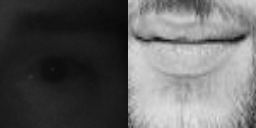

Label: 1


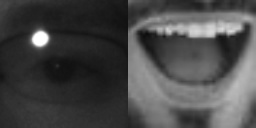

Label: 2


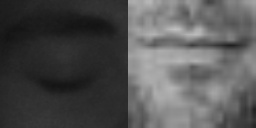

Label: 2


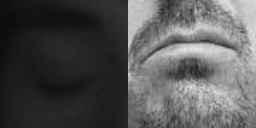

In [50]:
from IPython.display import Image, display

for i in range(4):
    print("Label:", train_df.iloc[i]['label'])
    display(Image(filename=train_df.iloc[i]['combined_image_path']))


CLASS: 0


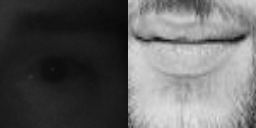


CLASS: 1


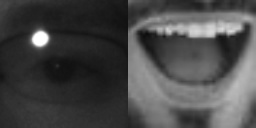


CLASS: 2


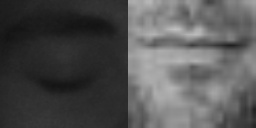

In [51]:
for c in range(3):
    sample = train_df[train_df['label'] == c].iloc[0]
    print("CLASS:", c)
    display(Image(filename=sample['combined_image_path']))
    print()
